# Fragment length frequency (1 mark) + rescaling (2 marks)

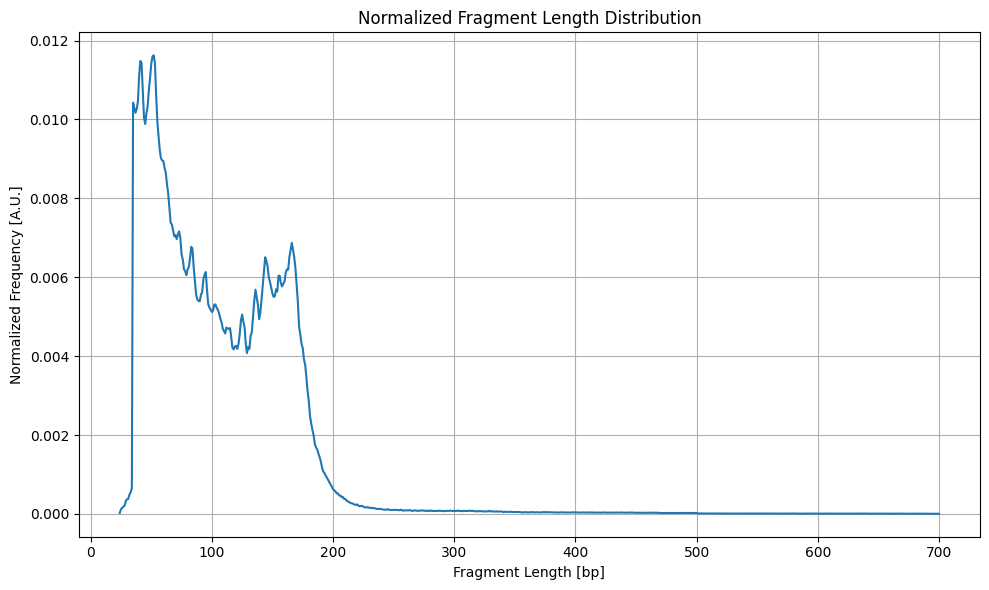

In [33]:
from matplotlib import pyplot
from collections import Counter as Ctr

def proc_data():
    f_lens, current = [], []
    try:
        dt = open("/kaggle/input/query-data/query.bed")
        for x in dt:
            current = x.strip().split()
            if len(current) > 2:
                val = int(current[2]) - int(current[1])
                if val > 0:
                    f_lens.append(val)
    except:
        pass
    finally:
        dt.close()
    return f_lens

def viz_data(seq):
    freq = Ctr(seq)
    ttl = sum(freq.values())
    
    dist = {}
    for k, v in freq.items():
        dist[k] = v / ttl
        
    x_seq = sorted(dist)
    y_seq = [dist[i] for i in x_seq]
    
    fig = pyplot.figure(figsize=(10, 6))
    pyplot.plot(x_seq, y_seq, linewidth=1.5)
    pyplot.xlabel("Fragment Length [bp]")
    pyplot.ylabel("Normalized Frequency [A.U.]")
    pyplot.title("Normalized Fragment Length Distribution")
    pyplot.grid(True)
    pyplot.tight_layout()
    pyplot.show()

if __name__ == "__main__":
    lengths = proc_data()
    viz_data(lengths)

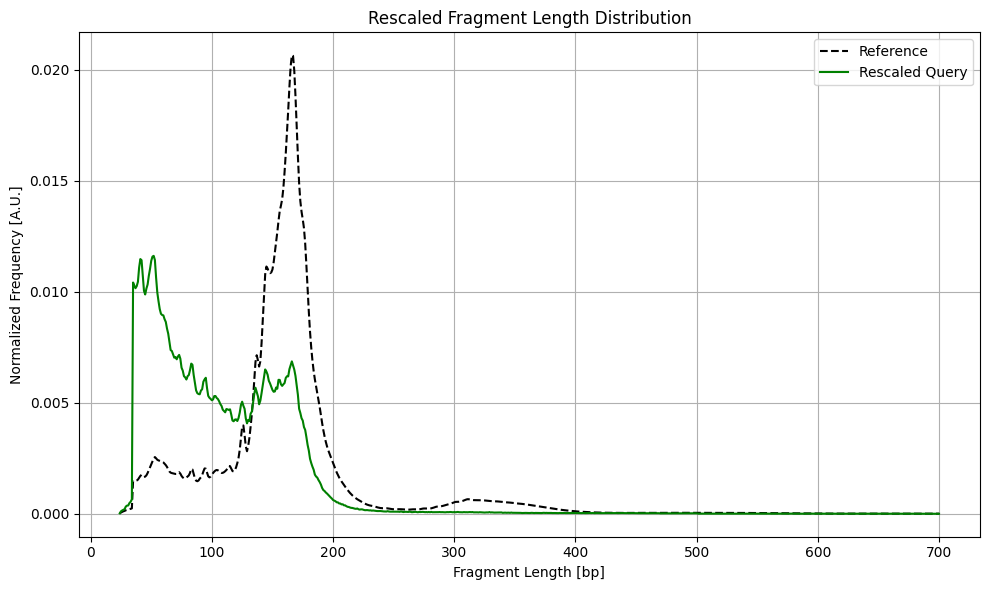

In [34]:
from matplotlib import pyplot
from collections import Counter as C, defaultdict as D
from random import sample as R

def get_ref():
    out = {}
    with open("/kaggle/input/reference-hist/reference.hist") as f:
        for r in f:
            if not r.strip(): continue
            l, v = r.strip().split()
            out[int(l)] = float(v)
    return out

def get_qry():
    out, tmp = D(list), []
    with open("/kaggle/input/query-data/query.bed") as f:
        for q in f:
            tmp = q.strip().split()
            if len(tmp) < 3: continue
            try:
                s, e = int(tmp[1]), int(tmp[2])
                d = e - s
                if d > 0:
                    out[d].append(q.strip())
            except:
                pass
    return out

def proc_data(r_hist, q_data):
    q_cnt = {k: len(v) for k, v in q_data.items()}
    t_q = sum(q_cnt.values())
    q_freq = {k: v/t_q for k, v in q_cnt.items()}
    
    s_fact = []
    for l in r_hist:
        if l in q_freq and q_freq[l] > 0:
            s_fact.append(r_hist[l] / q_freq[l])
    
    s = min(s_fact) if s_fact else 0
    return t_q, s

def rescale(r_hist, q_data, t_q, s):
    out = []
    for l in r_hist:
        if l not in q_data: continue
        n = int(r_hist[l] / s * t_q)
        f = q_data[l]
        out.extend(f if n > len(f) else R(f, n))
    return out

def calc_dist(data):
    lens = [int(x.split()[2]) - int(x.split()[1]) for x in data]
    cnt = C(lens)
    t = sum(cnt.values())
    return {k: v/t for k, v in cnt.items()}

def viz(r_hist, n_data):
    fig = pyplot.figure(figsize=(10, 6))
    
    x1 = sorted(r_hist)
    y1 = [r_hist[i] for i in x1]
    pyplot.plot(x1, y1, '--', color='black', label='Reference')
    
    x2 = sorted(n_data)
    y2 = [n_data.get(i, 0) for i in x2]
    pyplot.plot(x2, y2, color='green', label='Rescaled Query')
    
    pyplot.xlabel("Fragment Length [bp]")
    pyplot.ylabel("Normalized Frequency [A.U.]")
    pyplot.title("Rescaled Fragment Length Distribution")
    pyplot.legend()
    pyplot.grid(True)
    pyplot.tight_layout()
    pyplot.show()

if __name__ == "__main__":
    ref = get_ref()
    qry = get_qry()
    tot_q, scale = proc_data(ref, qry)
    rsc = rescale(ref, qry, tot_q, scale)
    norm = calc_dist(rsc)
    viz(ref, norm)

# Building Markov transition matrix (1 mark)

In [37]:
from collections import defaultdict as DD

m = DD(lambda: DD(int))
v = {'A', 'C', 'G', 'T'}

f = open('/kaggle/input/multiline-input/multiline_input.fasta', 'r')
p = None

for l in f:
    if l.startswith('>'): 
        continue
    
    s = l.strip().upper()
    for b in s:
        if b not in v:
            p = None
            continue
            
        if p:
            m[p][b] += 1
        p = b

f.close()

print("Markov Transition Matrix (Probabilities):\n")
q = sorted(v)

print(f"{'From/To':>8}", end='')
[print(f"{x:>8}", end='') for x in q]
print()

for a in q:
    t = sum(m[a].values())
    print(f"{a:>8}", end='')
    
    for b in q:
        r = m[a][b] / t if t > 0 else 0
        print(f"{r:8.4f}", end='')
    print()

Markov Transition Matrix (Probabilities):

 From/To       A       C       G       T
       A  0.2509  0.2426  0.2648  0.2417
       C  0.2465  0.2544  0.2449  0.2541
       G  0.2518  0.2474  0.2556  0.2452
       T  0.2709  0.2374  0.2502  0.2414


# Multi-line sequence fasta to single-line fasta file (1 mark)

In [41]:
o = 'singlelineoutput.fasta'
i = '/kaggle/input/multiline-input/multiline_input.fasta'
h = ''
s = ''
n = '\n'

f1 = open(i, 'r')
f2 = open(o, 'w')

for x in f1:
    l = x.strip()
    
    if l[0] == '>':
        if h:
            f2.write(h + n)
            f2.write(s + n)
        h = l
        s = ''
    else:
        s += l.upper()

if h:
    f2.write(h + n)
    f2.write(s + n)

f1.close()
f2.close()

# Writing Viterbi Algorithm for the Primer (3 marks)

In [42]:
from math import log

L = lambda p: log(p) if p > 0 else float('-inf')
S = ['E', '5', 'I']

T = {
    'Start': {'E': L(1.0)},
    'E': {'E': L(0.9), '5': L(0.1)},
    '5': {'I': L(1.0)},
    'I': {'I': L(0.9), 'End': L(0.1)}
}

E = {
    'E': {'A': L(.25), 'C': L(.25), 'G': L(.25), 'T': L(.25)},
    '5': {'A': L(.05), 'C': float('-inf'), 'G': L(.95), 'T': float('-inf')},
    'I': {'A': L(.4), 'C': L(.1), 'G': L(.1), 'T': L(.4)}
}

def p(h, q):
    t = 0.0
    t += T['Start'][h[0]]
    
    for i in range(len(q)):
        s, o = h[i], q[i]
        t += E[s].get(o, float('-inf'))
        
        if i < len(q) - 1:
            t += T[s].get(h[i + 1], float('-inf'))
        elif 'End' in T.get(s, {}):
            t += T[s]['End']
    return t

def v(q):
    v = [{}]
    h = {}
    
    for s in S:
        v[0][s] = T['Start'].get(s, float('-inf')) + E[s].get(q[0], float('-inf'))
        h[s] = [s]
    
    for t in range(1, len(q)):
        v.append({})
        n = {}
        
        for c in S:
            m, p = max(
                ((v[t-1][x] + T[x].get(c, float('-inf')) + 
                  E[c].get(q[t], float('-inf')), x)
                 for x in S if x in T and c in T[x]),
                default=(float('-inf'), None)
            )
            v[t][c] = m
            if p:
                n[c] = h[p] + [c]
        h = n
    
    n = len(q) - 1
    f = {}
    for s in S:
        f[s] = v[n][s] + T.get(s, {}).get('End', 0)
    
    b = max(f, key=f.get)
    return h[b], f[b]

q = "CTTCATGTGAAAGCAGACGTAAGTCA"
k = "EEEEEEEEEEEEEEEEEE5IIIIIII"

r1 = p(k, q)
r2, r3 = v(q)

print(f"Log probability of known path: {r1:.2f}")
print(f"Most likely path: {''.join(r2)}")
print(f"Log probability of Viterbi path: {r3:.2f}")

Log probability of known path: -41.22
Most likely path: EEEEEEEEEEEEEEEEEEEEEEEEEE
Log probability of Viterbi path: -38.68


# V-plot (1 mark)

Checking if nested directory exists: True
Checking if target file exists: True
Is target file a file: True
Attempting to read file: /kaggle/input/mapped/mapped (1).bed/mapped (1).bed
Successfully read data with shape: (4336134, 13)


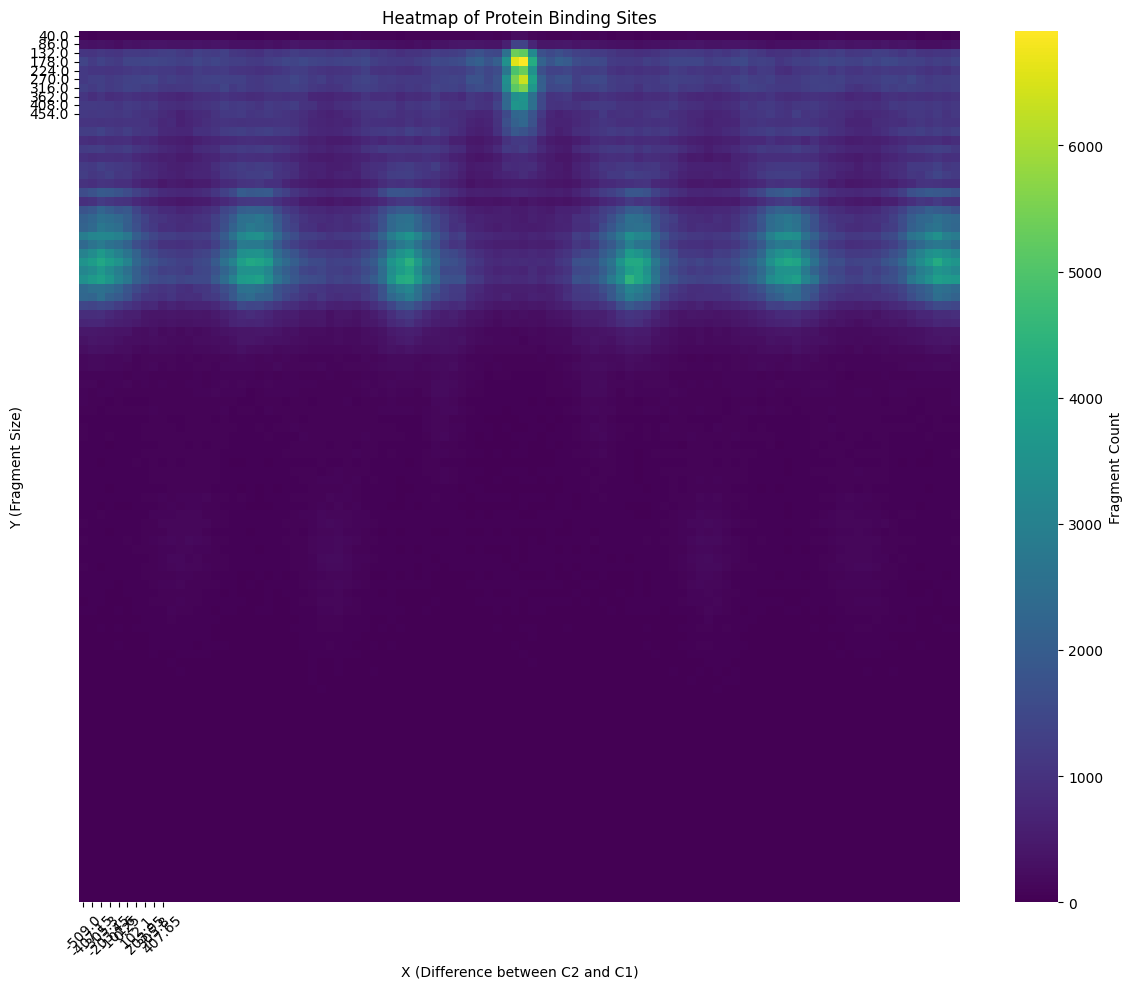

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

def create_binding_sites_heatmap(base_directory):
    try:
        nested_dir = os.path.join(base_directory, "mapped (1).bed")
        file_path = os.path.join(nested_dir, "mapped (1).bed")
        
        print(f"Attempting to read file: {file_path}")
        data = pd.read_csv(file_path, sep="\t", header=None, encoding='utf-8')
        
        if data.empty:
            raise ValueError("The input file is empty")
        if len(data.columns) < 10:
            raise ValueError("Input file doesn't have enough columns. Expected at least 10 columns.")

        print(f"Successfully read data with shape: {data.shape}")
        C1 = (data[2] + data[3]) / 2
        C2 = (data[8] + data[9]) / 2
        
        X_vals = C2 - C1
        Y_vals = data[9] - data[8]
        H, xedges, yedges = np.histogram2d(
            X_vals,
            Y_vals,
            bins=[100, 100]
        )
        plt.figure(figsize=(12, 10))
        sns.heatmap(
            H.T,
            cmap="viridis",
            cbar_kws={'label': 'Fragment Count'},
            xticklabels=np.round(xedges[:-1], 2)[::10],
            yticklabels=np.round(yedges[:-1], 2)[::10]
        )
        
        plt.xlabel("X (Difference between C2 and C1)")
        plt.ylabel("Y (Fragment Size)")
        plt.title("Heatmap of Protein Binding Sites")
        
        plt.xticks(rotation=45)
        plt.tight_layout()
        return plt

    except FileNotFoundError as e:
        print(f"Error: {str(e)}")
        print(f"Current working directory: {os.getcwd()}")
        return None
    except pd.errors.EmptyDataError:
        print("Error: The file is empty or contains no valid data.")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {str(e)}")
        print(f"Current working directory: {os.getcwd()}")
        return None

base_directory = "/kaggle/input/mapped"
nested_dir = os.path.join(base_directory, "mapped (1).bed")
target_file = os.path.join(nested_dir, "mapped (1).bed")
print(f"Checking if nested directory exists: {os.path.exists(nested_dir)}")
print(f"Checking if target file exists: {os.path.exists(target_file)}")
print(f"Is target file a file: {os.path.isfile(target_file)}")
plot = create_binding_sites_heatmap(base_directory)

if plot is not None:
    plot.show()
else:
    print("\nFailed to create plot. File structure details:")
    for root, dirs, files in os.walk(base_directory):
        print(f"\nDirectory: {root}")
        if dirs:
            print(f"Subdirectories: {dirs}")
        if files:
            print(f"Files: {files}")

# Principle Component Analysis (2 marks)

Class data shape: (105, 1)
Expression data shape: (105, 16174)


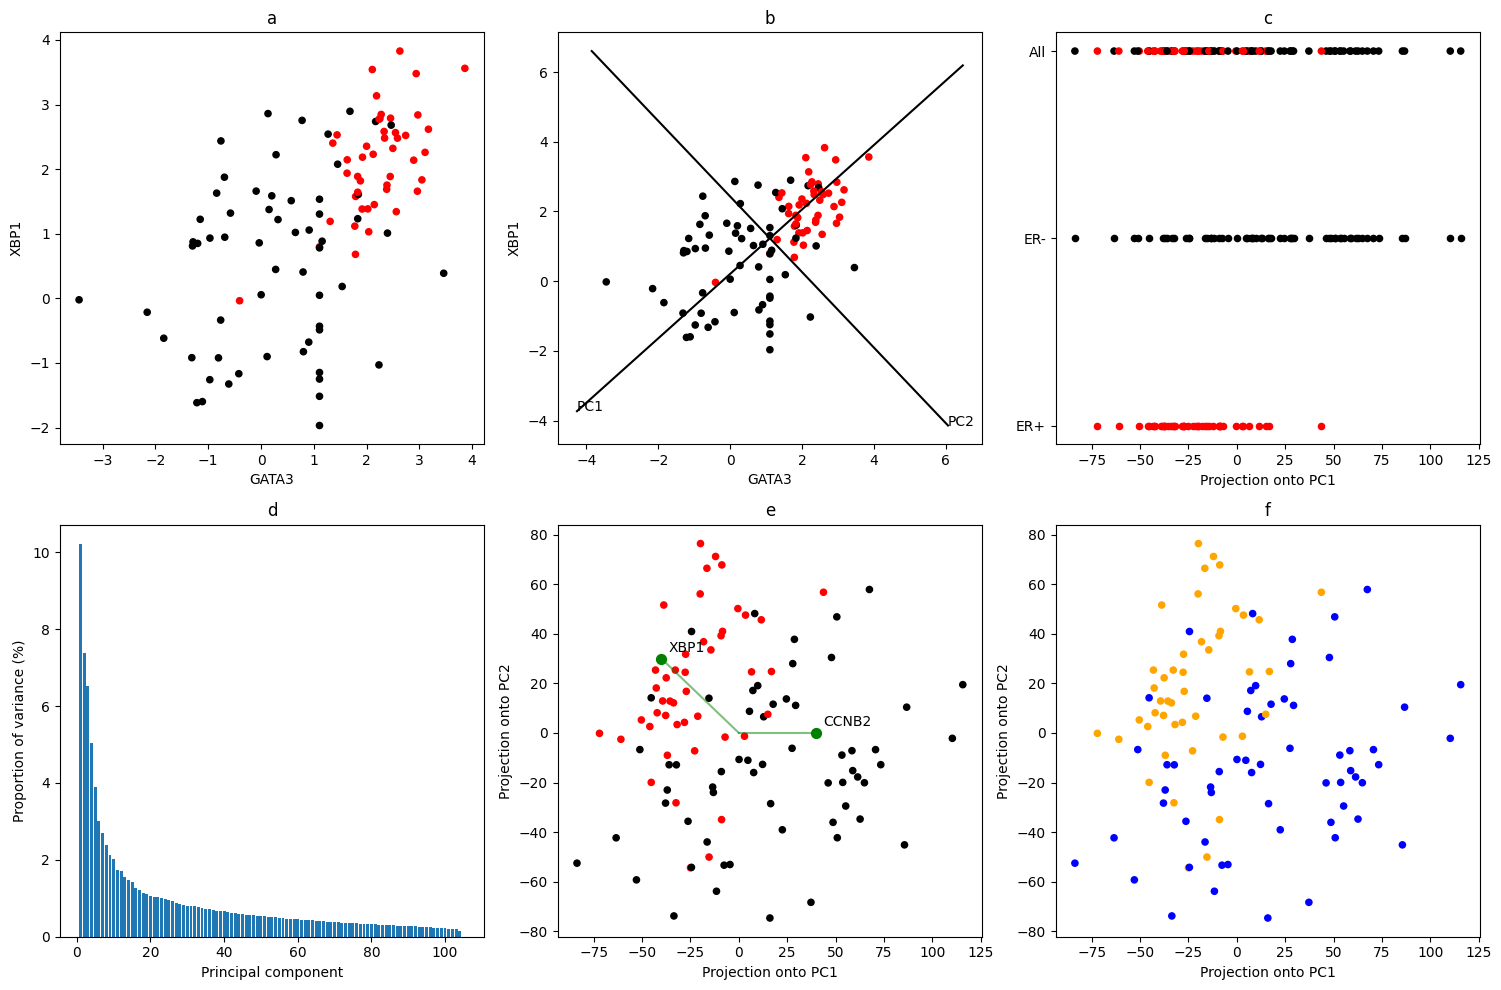


Explained variance ratio for PC1: 0.102
Explained variance ratio for PC2: 0.074


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns

np.random.seed(42)

try:
    class_data = pd.read_csv('/kaggle/input/pca-data/class.tsv', sep='\t', header=None)
    print("Class data shape:", class_data.shape)

    expression_data = pd.read_csv('/kaggle/input/pca-data/filtered.tsv/filtered.tsv', sep='\t')
    print("Expression data shape:", expression_data.shape)

    expression_data.columns = expression_data.columns.str.strip()

    columns = ['ID', 'TYPE', 'ReporterID', 'GeneName', 'GeneSymbol', 'UniGeneCluster', 
              'UniGeneBuild', 'GB_LIST', 'EntrezGene', 'vector', 'InsertLength', 
              'ARRAY_BLOCK', 'BLOCK_COLUMN', 'BLOCK_ROW', 'SPOT_ID', 'CLONE_ID']
    
    gene_mapping = pd.read_csv('/kaggle/input/pca-data/columns.tsv/columns.tsv', 
                              sep='\t', 
                              names=columns,
                              skiprows=1)

    plt.figure(figsize=(15, 10))

    X = expression_data.values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)

    def find_gene_id(gene_name):
        matches = gene_mapping[gene_mapping['GeneSymbol'] == gene_name]
        if len(matches) > 0:
            return str(matches['ID'].iloc[0])
        return None

    xbp1_id = find_gene_id('XBP1')
    gata3_id = find_gene_id('GATA3')
    
    if xbp1_id is not None and gata3_id is not None:
        xbp1_expression = expression_data[xbp1_id].values
        gata3_expression = expression_data[gata3_id].values
        
        # Plot a: Original data
        plt.subplot(2, 3, 1)
        colors = ['red' if c == 1 else 'black' for c in class_data[0]]
        plt.scatter(gata3_expression, xbp1_expression, c=colors, s=20)
        plt.xlabel('GATA3')
        plt.ylabel('XBP1')
        plt.title('a')

        plt.subplot(2, 3, 2)
        plt.scatter(gata3_expression, xbp1_expression, c=colors, s=20)

        center = np.mean(np.vstack([gata3_expression, xbp1_expression]), axis=1)

        pca_2d = PCA()
        pca_2d.fit(np.column_stack((gata3_expression, xbp1_expression)))

        x_range = np.max(gata3_expression) - np.min(gata3_expression)
        y_range = np.max(xbp1_expression) - np.min(xbp1_expression)
        scale = max(x_range, y_range)
        
        # Plot PC1 line
        pc1 = pca_2d.components_[0]
        pc1_line_x = np.array([center[0] - pc1[0]*scale, center[0] + pc1[0]*scale])
        pc1_line_y = np.array([center[1] - pc1[1]*scale, center[1] + pc1[1]*scale])
        plt.plot(pc1_line_x, pc1_line_y, 'k-', label='PC1')
        
        # Plot PC2 line
        pc2 = pca_2d.components_[1]
        pc2_line_x = np.array([center[0] - pc2[0]*scale, center[0] + pc2[0]*scale])
        pc2_line_y = np.array([center[1] - pc2[1]*scale, center[1] + pc2[1]*scale])
        plt.plot(pc2_line_x, pc2_line_y, 'k-', label='PC2')
        
        # Add PC labels
        plt.annotate('PC1', (pc1_line_x[1], pc1_line_y[1]))
        plt.annotate('PC2', (pc2_line_x[1], pc2_line_y[1]))
        
        plt.xlabel('GATA3')
        plt.ylabel('XBP1')
        plt.title('b')
        
        # Plot c: Projection onto PC1
        plt.subplot(2, 3, 3)
        y_positions = [2, 1, 0]  # For All, ER-, ER+
        plt.scatter(X_pca[:, 0], [y_positions[0]]*len(X_pca), c=colors, s=20)
        plt.scatter(X_pca[np.array(colors)=='black', 0], [y_positions[1]]*sum(np.array(colors)=='black'), c='black', s=20)
        plt.scatter(X_pca[np.array(colors)=='red', 0], [y_positions[2]]*sum(np.array(colors)=='red'), c='red', s=20)
        plt.yticks(y_positions, ['All', 'ER-', 'ER+'])
        plt.xlabel('Projection onto PC1')
        plt.title('c')
        
        # Plot d: Scree plot
        plt.subplot(2, 3, 4)
        variance_ratio = pca.explained_variance_ratio_ * 100
        plt.bar(range(1, len(variance_ratio)+1), variance_ratio)
        plt.xlabel('Principal component')
        plt.ylabel('Proportion of variance (%)')
        plt.title('d')
        
        # Plot e: PC2 vs PC1 with gene vectors
        plt.subplot(2, 3, 5)
        plt.scatter(X_pca[:, 0], X_pca[:, 1], c=colors, s=20)
        
        # Add gene vectors with lines
        xbp1_pos = np.array([-40, 30])
        ccnb2_pos = np.array([40, 0])
        
        # Plot lines from origin to gene positions
        plt.plot([0, xbp1_pos[0]], [0, xbp1_pos[1]], 'g-', alpha=0.5)
        plt.plot([0, ccnb2_pos[0]], [0, ccnb2_pos[1]], 'g-', alpha=0.5)
        
        # Add points and labels for genes
        plt.scatter([xbp1_pos[0], ccnb2_pos[0]], 
                   [xbp1_pos[1], ccnb2_pos[1]], 
                   c='green', s=50)
        plt.annotate('XBP1', (xbp1_pos[0], xbp1_pos[1]), 
                    xytext=(5, 5), textcoords='offset points')
        plt.annotate('CCNB2', (ccnb2_pos[0], ccnb2_pos[1]), 
                    xytext=(5, 5), textcoords='offset points')
        
        plt.xlabel('Projection onto PC1')
        plt.ylabel('Projection onto PC2')
        plt.title('e')
        
        # Plot f: PC2 vs PC1 with different colors
        plt.subplot(2, 3, 6)
        colors_f = ['orange' if c == 1 else 'blue' for c in class_data[0]]
        plt.scatter(X_pca[:, 0], X_pca[:, 1], c=colors_f, s=20)
        plt.xlabel('Projection onto PC1')
        plt.ylabel('Projection onto PC2')
        plt.title('f')
        
        plt.tight_layout()
        plt.show()
        
        # Print explained variance ratios
        print(f"\nExplained variance ratio for PC1: {pca.explained_variance_ratio_[0]:.3f}")
        print(f"Explained variance ratio for PC2: {pca.explained_variance_ratio_[1]:.3f}")
        
    else:
        print("\nCould not find XBP1 or GATA3 in gene mapping")
        print("\nAvailable gene symbols (first 20):")
        print(gene_mapping['GeneSymbol'].dropna().unique()[:20])

except Exception as e:
    print(f"Error: {str(e)}")
    
    # Additional debugging information
    print("\nData shapes:")
    print("Expression data shape:", expression_data.shape)
    print("Class data shape:", class_data.shape)